In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
sns.set()
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]

In [2]:
#cars = pd.read_csv("vehicles.csv")
cars = pd.read_csv("vehicles_na_cleaned.csv")
cars = cars.drop(columns=["cylinders"])
cars = cars[(cars["price"] < 100000) & (cars["price"] > 100)]
cars = cars[
    (cars["odometer"] < 600000.0) & 
    ((cars["odometer"] > 100) | (cars["condition"] == "new"))
]

Looking at the data, some features might not be relevant for the analysis and I'll drop them so I don't have to load into memory redundant information. This should also decrease the size of the dataset on disk. I don't play to use any of these features in an initial analysis and eventually come back to them if the models aren't doing well at all.

Some columns that have missing data, contain some information in the description column or in the model column. I'll try to backfill the data in case I will use these features later on.

In [3]:
def backfill_column(x, column_name, values):
    if pd.notna(x[column_name]):
        return x[column_name]
    
    for value in values:        
        if value in str(x["description"]) or value in str(x["model"]):
            return value

In [4]:
# Only needed if working on the initial dataset
# cars = cars.drop(columns=["id", "url", "VIN", "image_url", "county", "posting_date", "size"])

# manufacturer = set(cars["manufacturer"].astype(str).unique())
# fuel = set(cars["fuel"].astype(str).unique())
# color = set(cars["paint_color"].astype(str).unique())
# car_type = set(cars["type"].astype(str).unique())
# cars["manufacturer"] = cars.apply(lambda x: backfill_column(x, "manufacturer", manufacturer), axis=1)
# cars["fuel"] = cars.apply(lambda x: backfill_column(x, "fuel", fuel), axis=1)
# cars["paint_color"] = cars.apply(lambda x: backfill_column(x, "paint_color", color), axis=1)
# cars["type"] = cars.apply(lambda x: backfill_column(x, "type", car_type), axis=1)

# cars = cars.drop(columns=["model", "description"])
# cars = cars.dropna(subset=["lat", "long", "odometer", "year", "fuel", "transmission", "manufacturer"])

# cars.to_csv("vehicles_na_cleaned.csv")

### What's the percentage of missing values for each feature ? 

In [5]:
nr_cars = len(cars)
cars.isna().sum()/nr_cars

Unnamed: 0      0.000000
region          0.000000
region_url      0.000000
price           0.000000
year            0.000000
manufacturer    0.004138
condition       0.373658
fuel            0.001824
odometer        0.000000
title_status    0.017643
transmission    0.000000
drive           0.301553
type            0.149546
paint_color     0.234623
state           0.000000
lat             0.000000
long            0.000000
dtype: float64

County seems to be a useless column so will drop this as well. Size also seems to be present in less than 30% of observations so again will drop this as well. 

Some ideas about the columns, and how I plan to use them:
- ~~year - there are so few observations missing year that might not even worth bothering so will check if we can drop those observations whatsoever~~
- ~~model - cleaning up this column might definitely be worth the effort, I'll just do some basic replacements and see if the number of unique values decreases. 
This still gives me around 15000 unique values, even if I tried to simply substring up to 10 characters and do some replacements. Will see if this is worth using as a feature.~~
- condition, 40% missing, will replace missing with "unspecified"
- cylinders, 40% missing, will replace missing with "unspecified"
- ~~fuel - will drop the 7% of observations that don't have fuel~~
- ~~odometer - I feel like this is going to be fairly good predictor so will just round them to the nears 10s. Went down to 66 unique values this way.~~
- title status, 20% missing, will replace missing with "unspecified"
- ~~transmission - will drop the records with missing values~~
- drive, 30% missing, replace missing with "unspecified"
- ~~size, 70% missing, don't consider it as a feature~~
- type, 20% missing, replace or drop 
- paint_color - 30% replace with unknown
- ~~lat/long - I could replace the lat/long with the coordinates of the state biggest city, but for now will drop the missing ones as they are just 1%~~

In [6]:
categories = [
    "fuel", 
    "transmission", 
    "region", 
    "manufacturer",
    "title_status", 
    "drive", 
    "type", 
    "paint_color", 
    "state",
    "condition"
]
cars["year"] = cars["year"].astype("int")
cars["lat"] = cars["lat"].astype("float64")
cars["long"] = cars["long"].astype("float64")

In [7]:
cars.describe()

,Unnamed: 0,price,year,odometer,lat,long
count,367799.000000,367799.000000,367799.000000,367799.000000,367799.000000,367799.000000
mean,213286.986074,18891.287056,2011.331309,93583.522160,38.560756,-94.426999
std,122846.208270,14319.214044,8.858698,63424.059415,5.848957,18.138161
min,27.000000,101.000000,1900.000000,0.000000,-81.838232,-159.719900
25%,108082.000000,7500.000000,2008.000000,39624.000000,34.737481,-110.993712
50%,211283.000000,15590.000000,2013.000000,88107.000000,39.287000,-88.065001
75%,319673.500000,27900.000000,2017.000000,135955.500000,42.440000,-80.927120
max,426879.000000,99999.000000,2022.000000,590000.000000,82.390818,167.629911


It looks like it's safe to drop everything that has a price over 100000 as the sample contains a negligeable number of observations with that price. There are also 26000 observations with the price 0. The hypothesis here is that these are probably cars that are either given out for free or just bad data. Will remove them as well.

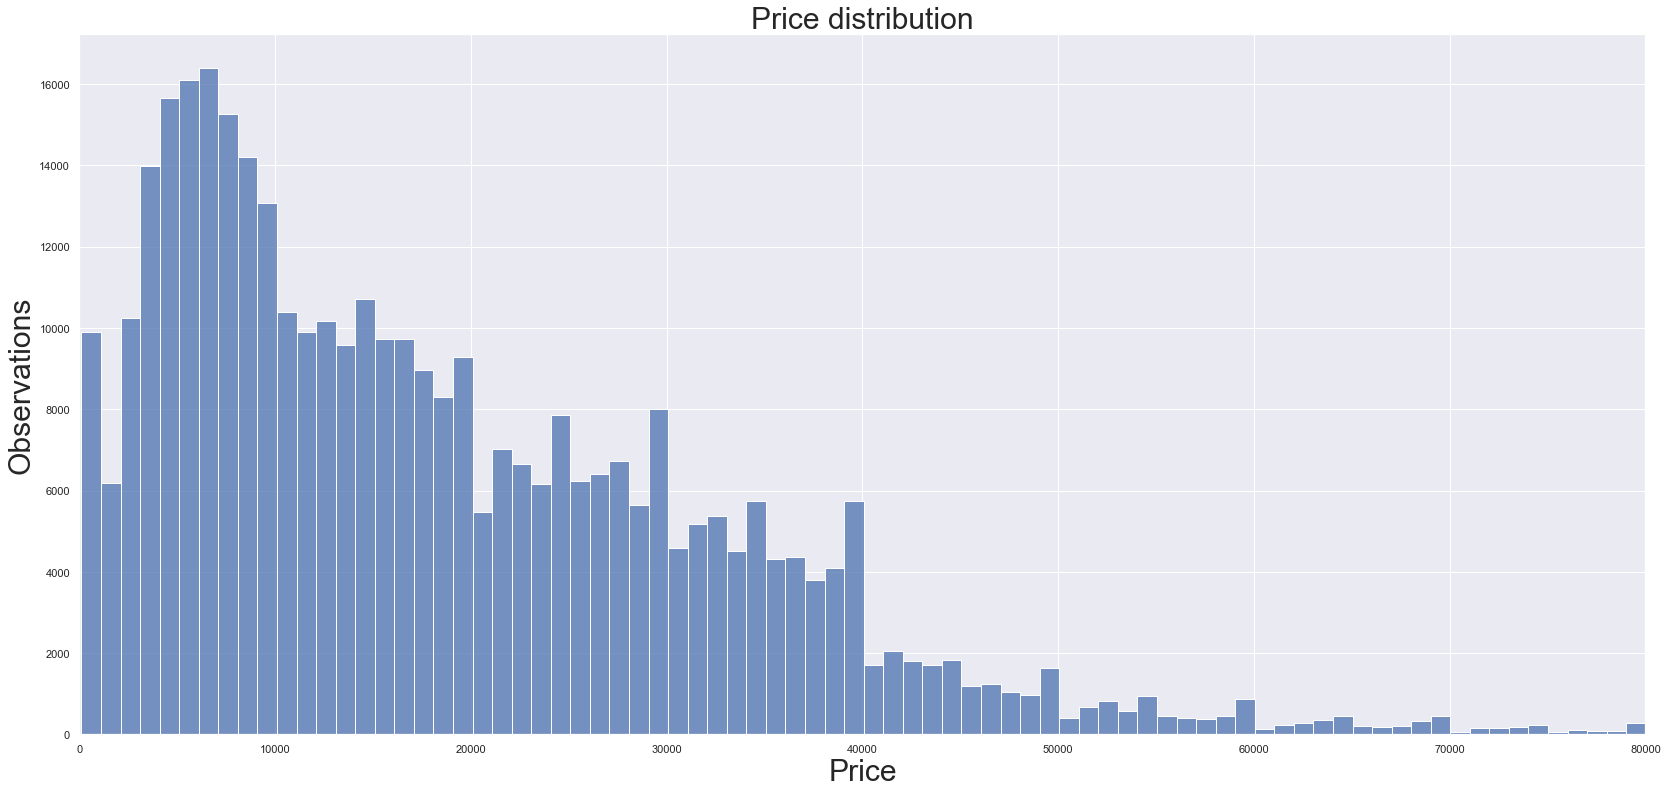

In [8]:
fig, ax = plt.subplots()
p = sns.histplot(cars["price"], bins=100)
p.axes.set_title("Price distribution",fontsize=30)
p.set_xlabel("Price",fontsize=30)
p.set_ylabel("Observations",fontsize=30)
plt.xlim([0, 80000])
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')
plt.show()

#### Distribution of prices by existing properties

Text(0, 0.5, 'Density')

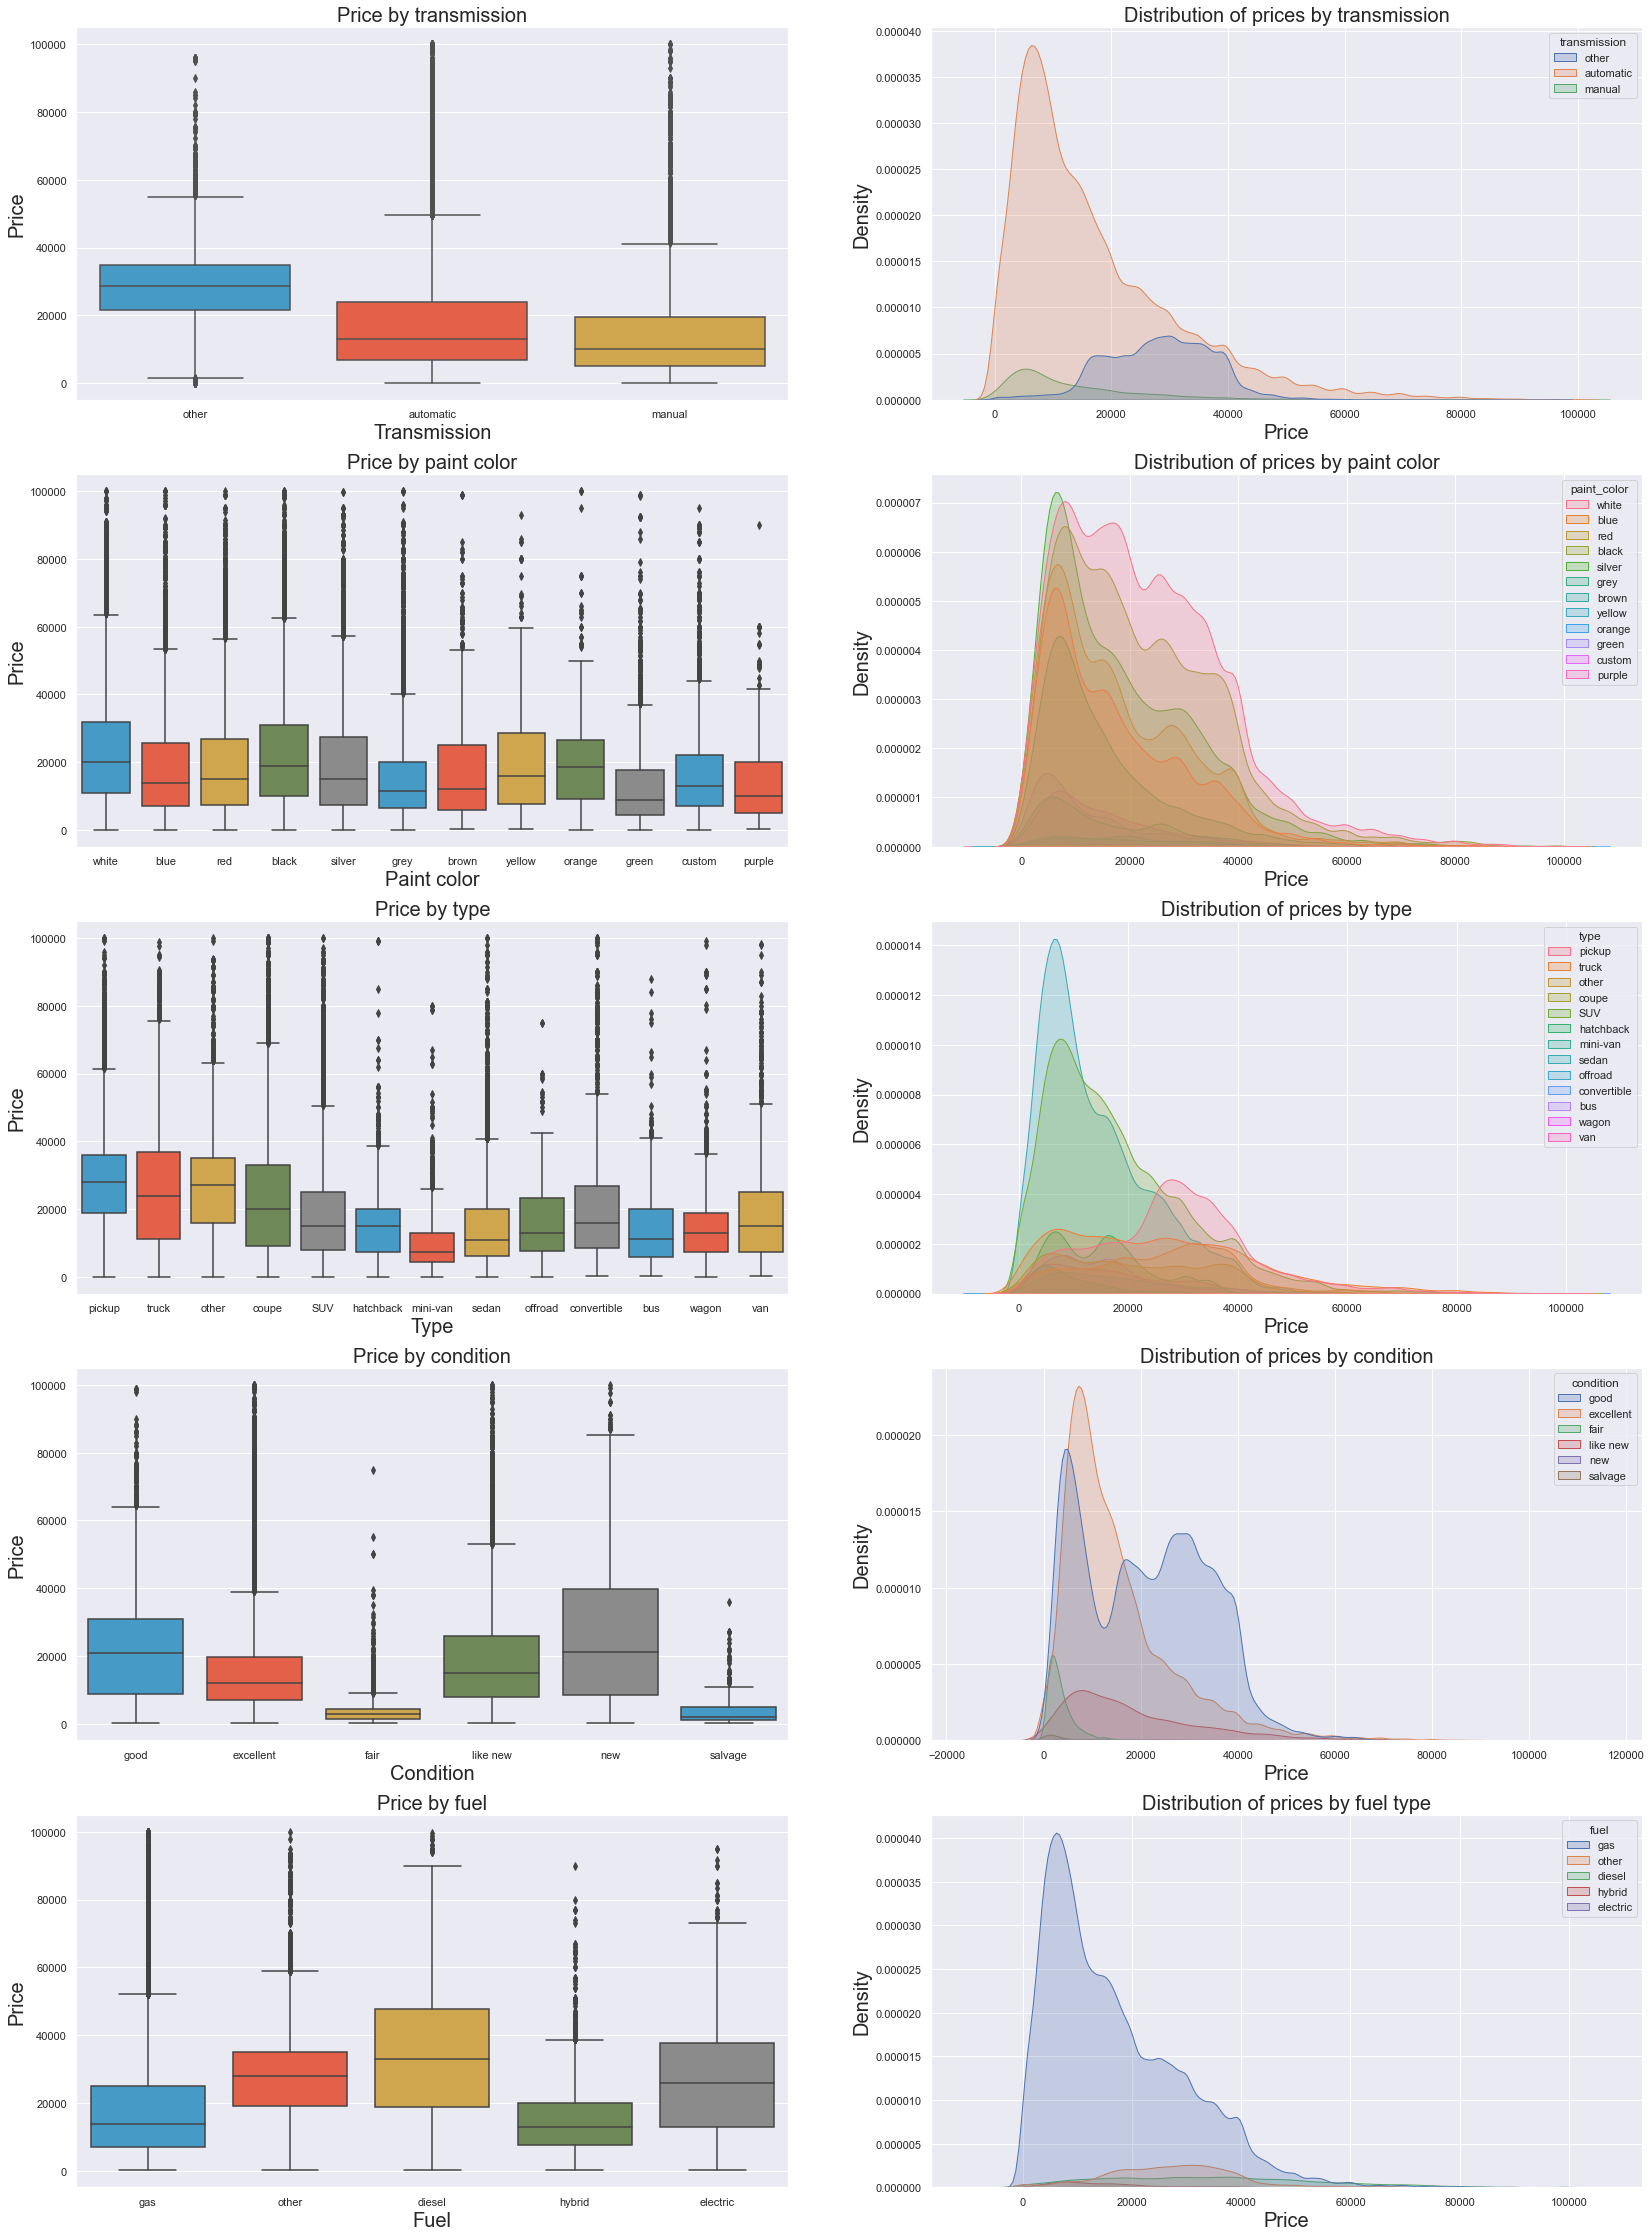

In [9]:
plt.subplot(5, 2, 1)
plt.subplots_adjust(bottom=5, top=7.5)
p = sns.boxplot(
    x="transmission", y="price", palette=five_thirty_eight,
    data=cars
)
p.set_title("Price by transmission", fontsize=20)
p.set_xlabel("Transmission", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 2)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="transmission", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by transmission", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 3)
p = sns.boxplot(
    x="paint_color", y="price", palette=five_thirty_eight,
    data=cars
)
p.set_title("Price by paint color", fontsize=20)
p.set_xlabel("Paint color", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 4)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="paint_color", fill=True, data=cars)
p.set_title("Distribution of prices by paint color", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 5)
p = sns.boxplot(
    x="type", y="price", palette=five_thirty_eight,
    data=cars
)
p.set_title("Price by type", fontsize=20)
p.set_xlabel("Type", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 6)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="type", fill=True, data=cars)
p.set_title("Distribution of prices by type", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)

plt.subplot(5, 2, 7)
p = sns.boxplot(
    x="condition", y="price", palette=five_thirty_eight,
    data=cars
)
p.set_title("Price by condition", fontsize=20)
p.set_xlabel("Condition", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 8)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="condition", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by condition", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)


plt.subplot(5, 2, 9)
p = sns.boxplot(
    x="fuel", y="price", palette=five_thirty_eight,
    data=cars
)
p.set_title("Price by fuel", fontsize=20)
p.set_xlabel("Fuel", fontsize=20)
p.set_ylabel("Price", fontsize=20)
plt.subplot(5, 2, 10)
plt.ticklabel_format(style='plain', axis='y')
p = sns.kdeplot(x="price", hue="fuel", fill=True, common_norm=True, data=cars)
p.set_title("Distribution of prices by fuel type", fontsize=20)
p.set_xlabel("Price", fontsize=20)
p.set_ylabel("Density", fontsize=20)



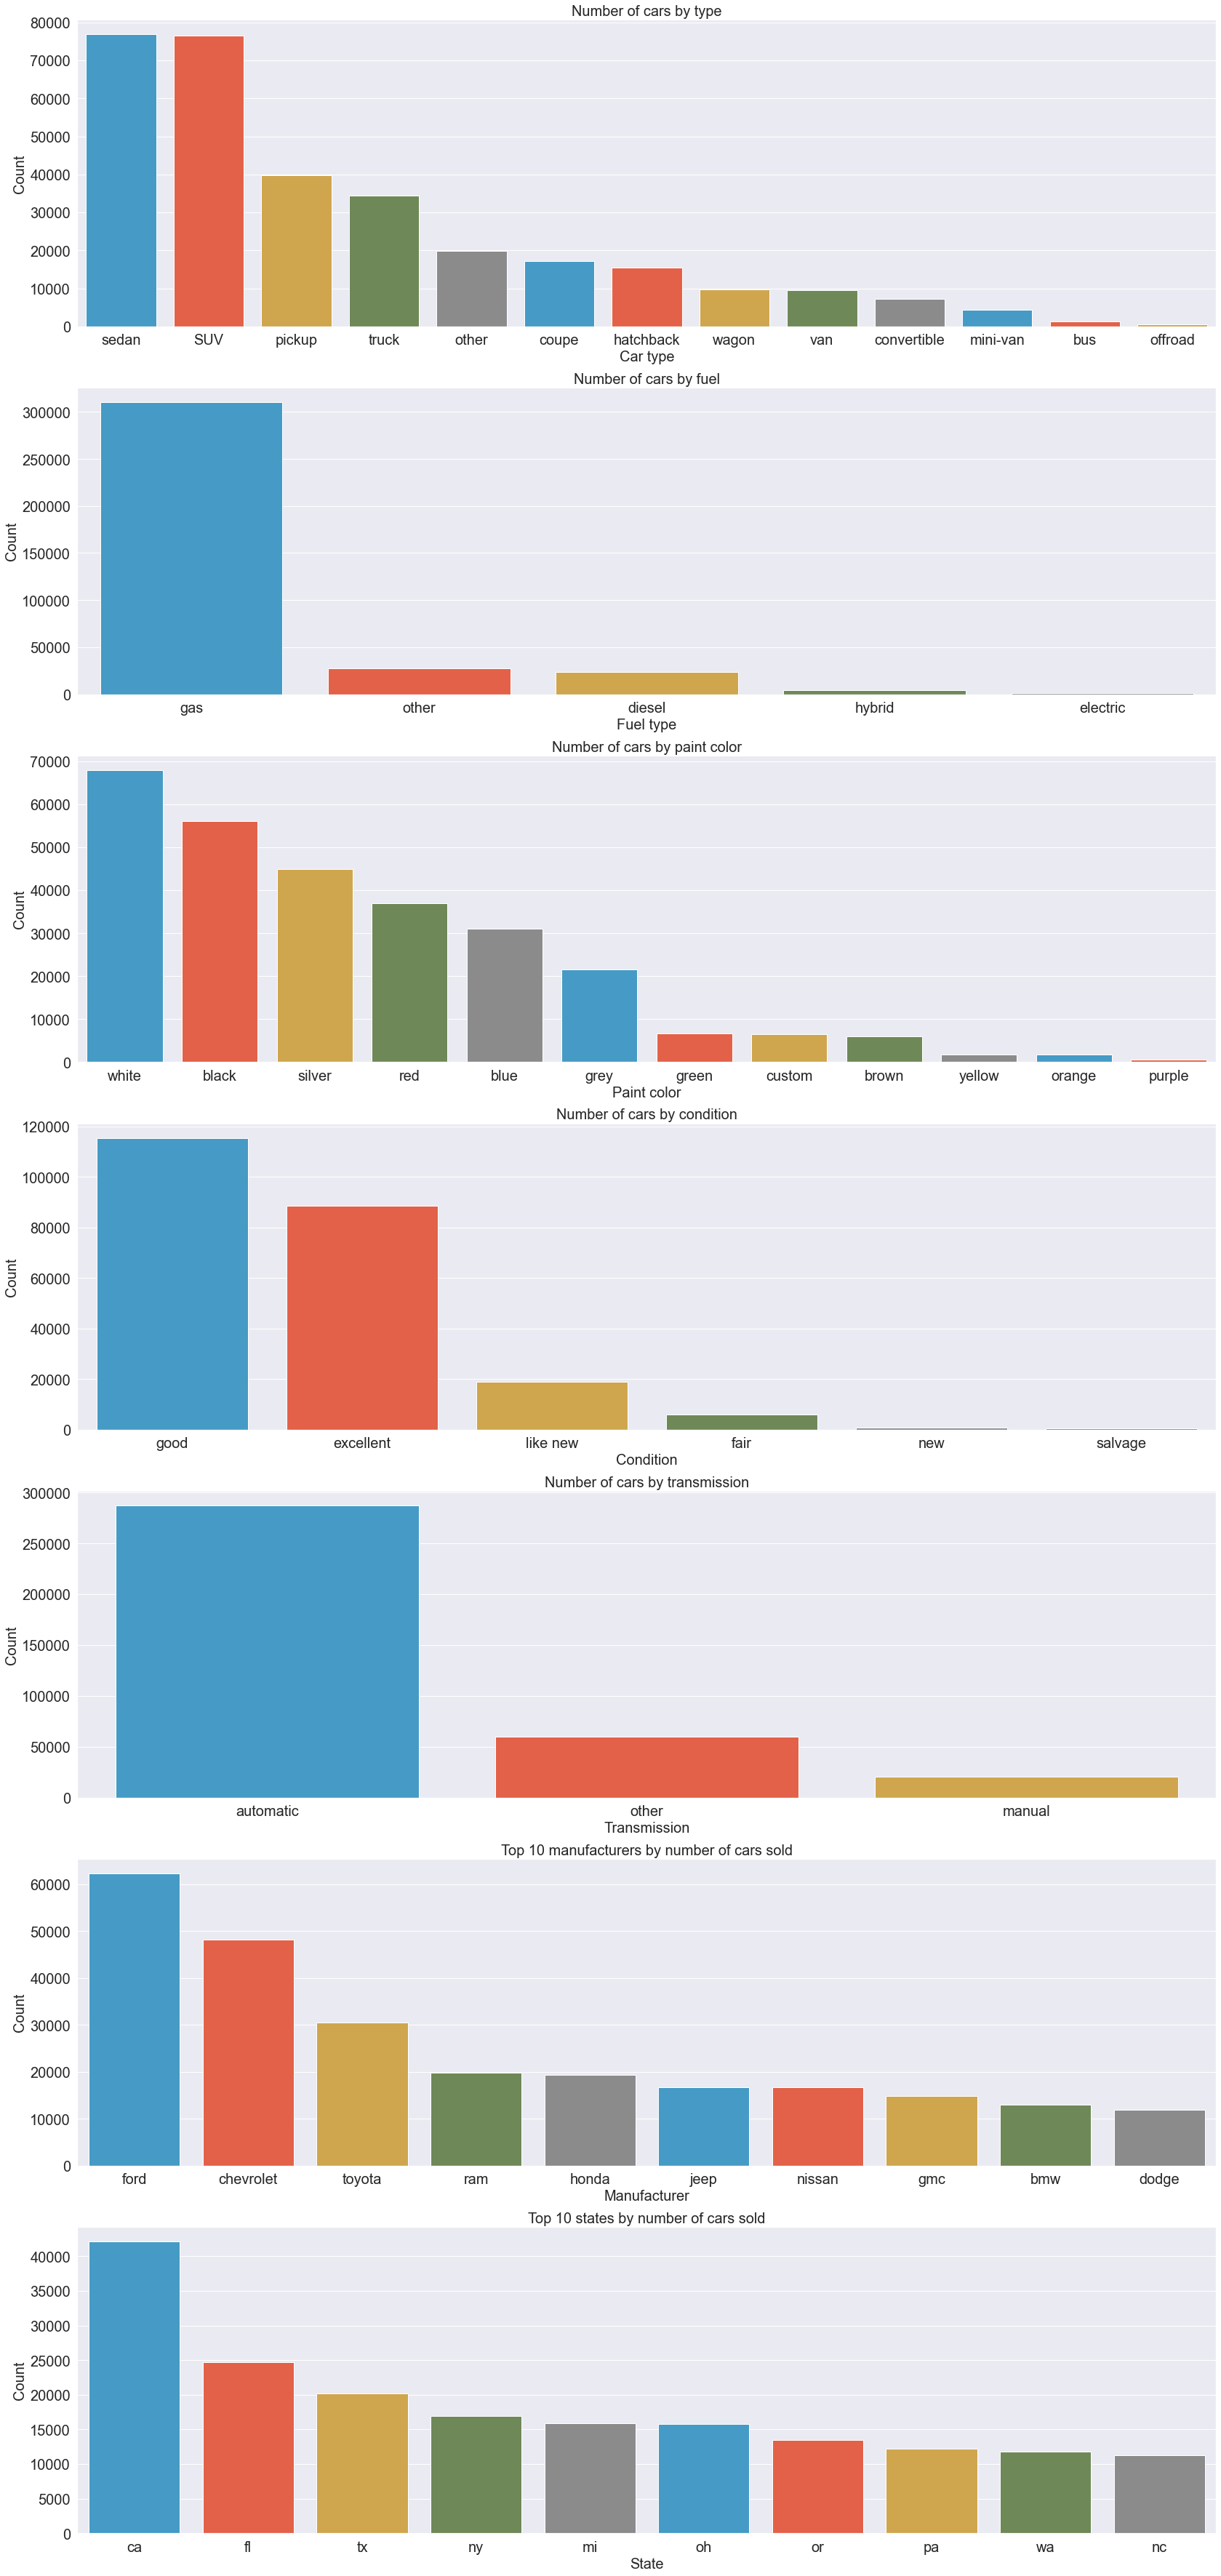

In [10]:
plt.subplots_adjust(bottom=4, top=8)
plt.subplot(7, 1, 1)
p = sns.countplot(
    x="type",
    order=cars["type"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by type", fontsize=20)
p.set_xlabel("Car type", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 2)
p = sns.countplot(
    x="fuel", 
    order=cars["fuel"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by fuel", fontsize=20)
p.set_xlabel("Fuel type", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 3)
p = sns.countplot(
    x="paint_color", 
    order=cars["paint_color"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by paint color", fontsize=20)
p.set_xlabel("Paint color", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 4)
p = sns.countplot(
    x="condition", 
    order=cars["condition"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by condition", fontsize=20)
p.set_xlabel("Condition", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 5)
p = sns.countplot(
    x="transmission", 
    order=cars["transmission"].value_counts().index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Number of cars by transmission", fontsize=20)
p.set_xlabel("Transmission", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)


plt.subplot(7, 1, 6)
p = sns.countplot(
    x="manufacturer", 
    order=cars["manufacturer"].value_counts().iloc[:10].index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Top 10 manufacturers by number of cars sold", fontsize=20)
p.set_xlabel("Manufacturer", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

plt.subplot(7, 1, 7)
p = sns.countplot(
    x="state", 
    order=cars["state"].value_counts().iloc[:10].index,
    palette=five_thirty_eight,
    data=cars)
p.set_title("Top 10 states by number of cars sold", fontsize=20)
p.set_xlabel("State", fontsize=20)
p.set_ylabel("Count", fontsize=20)
p.tick_params(labelsize=20)

#### Numerical variables. Are they correlated with price ?

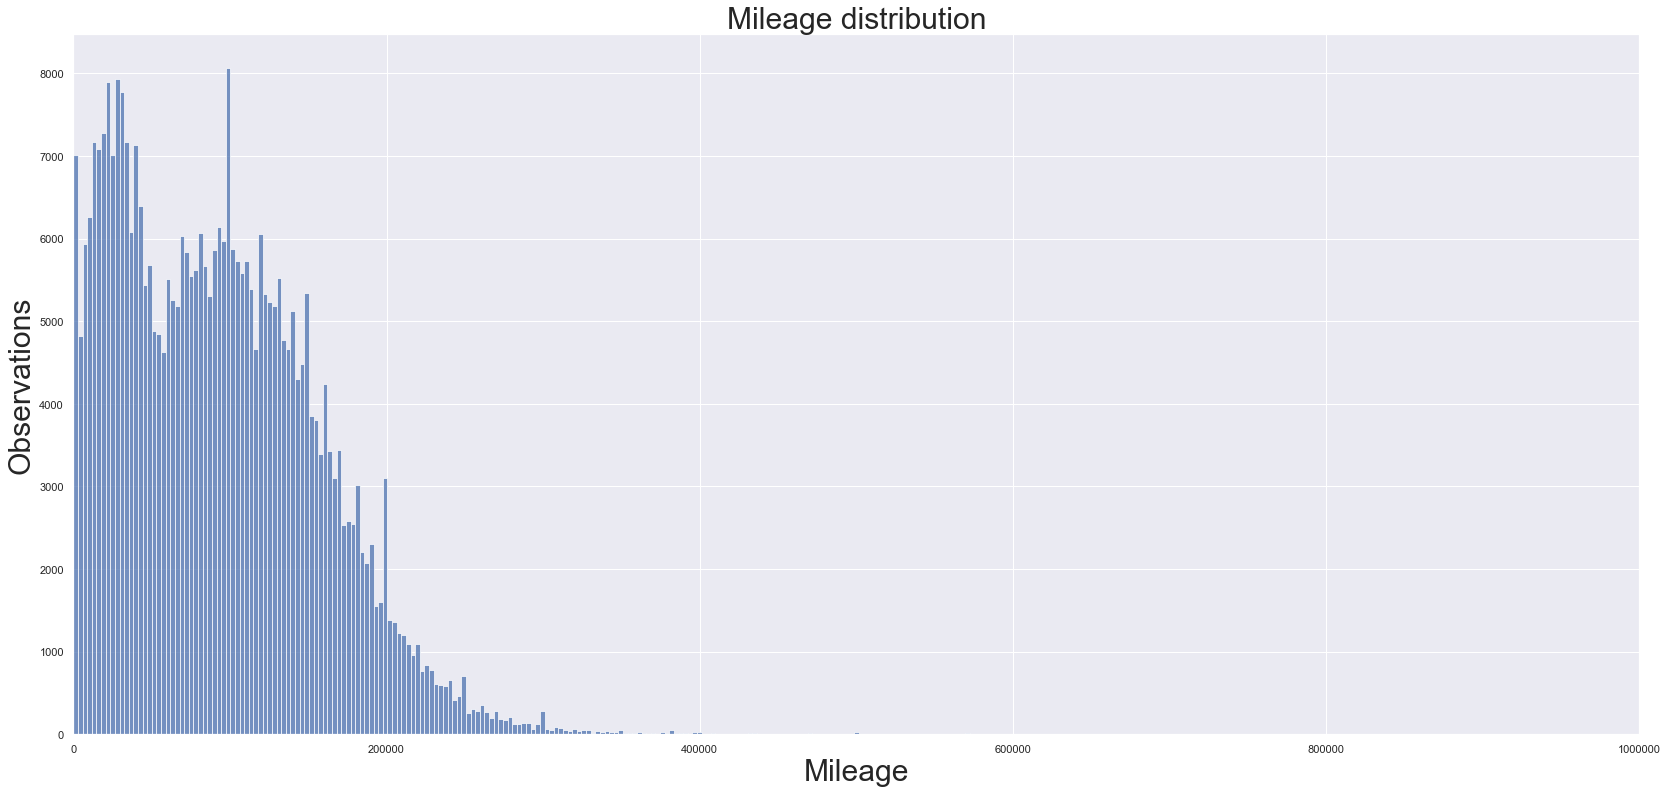

In [11]:
fig, ax = plt.subplots()
p = sns.histplot(cars["odometer"], bins=200)
p.axes.set_title("Mileage distribution",fontsize=30)
p.set_xlabel("Mileage",fontsize=30)
p.set_ylabel("Observations",fontsize=30)
plt.xlim([0, 1000000])
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')
plt.show()

Text(0, 0.5, 'Price')

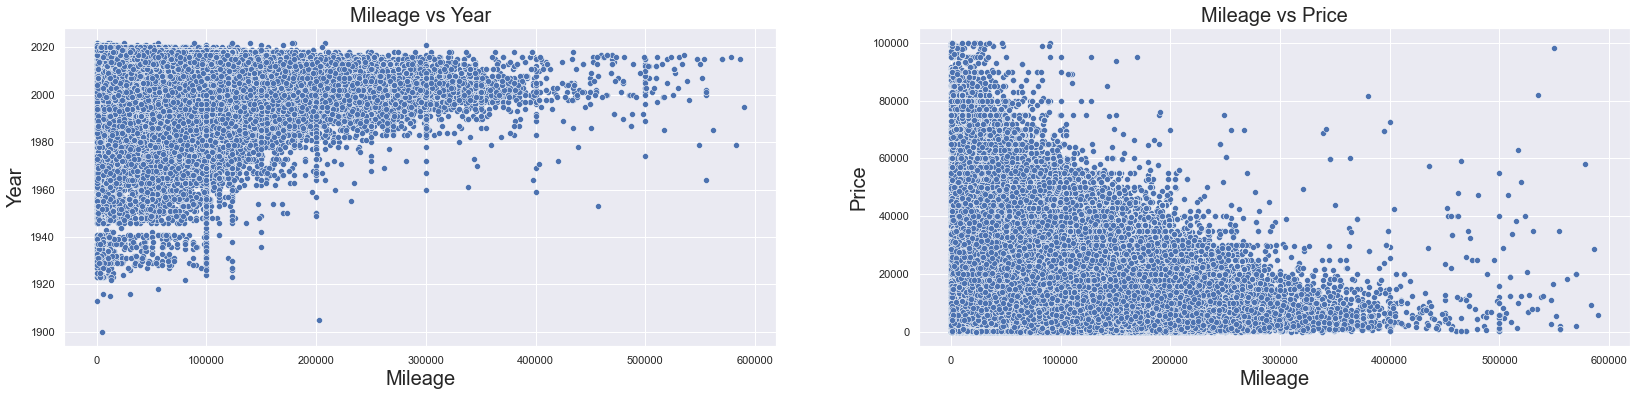

In [12]:
plt.subplot(2, 2, 1)
plt.ticklabel_format(style='plain', axis='x')
p = sns.scatterplot(x="odometer", y="year", data=cars)
p.set_title("Mileage vs Year", fontsize=20)
p.set_xlabel("Mileage", fontsize=20)
p.set_ylabel("Year", fontsize=20)
plt.subplot(2, 2, 2)
plt.ticklabel_format(style='plain', axis='x')
p = sns.scatterplot(x="odometer", y="price", data=cars)
p.set_title("Mileage vs Price", fontsize=20)
p.set_xlabel("Mileage", fontsize=20)
p.set_ylabel("Price", fontsize=20)

<AxesSubplot:>

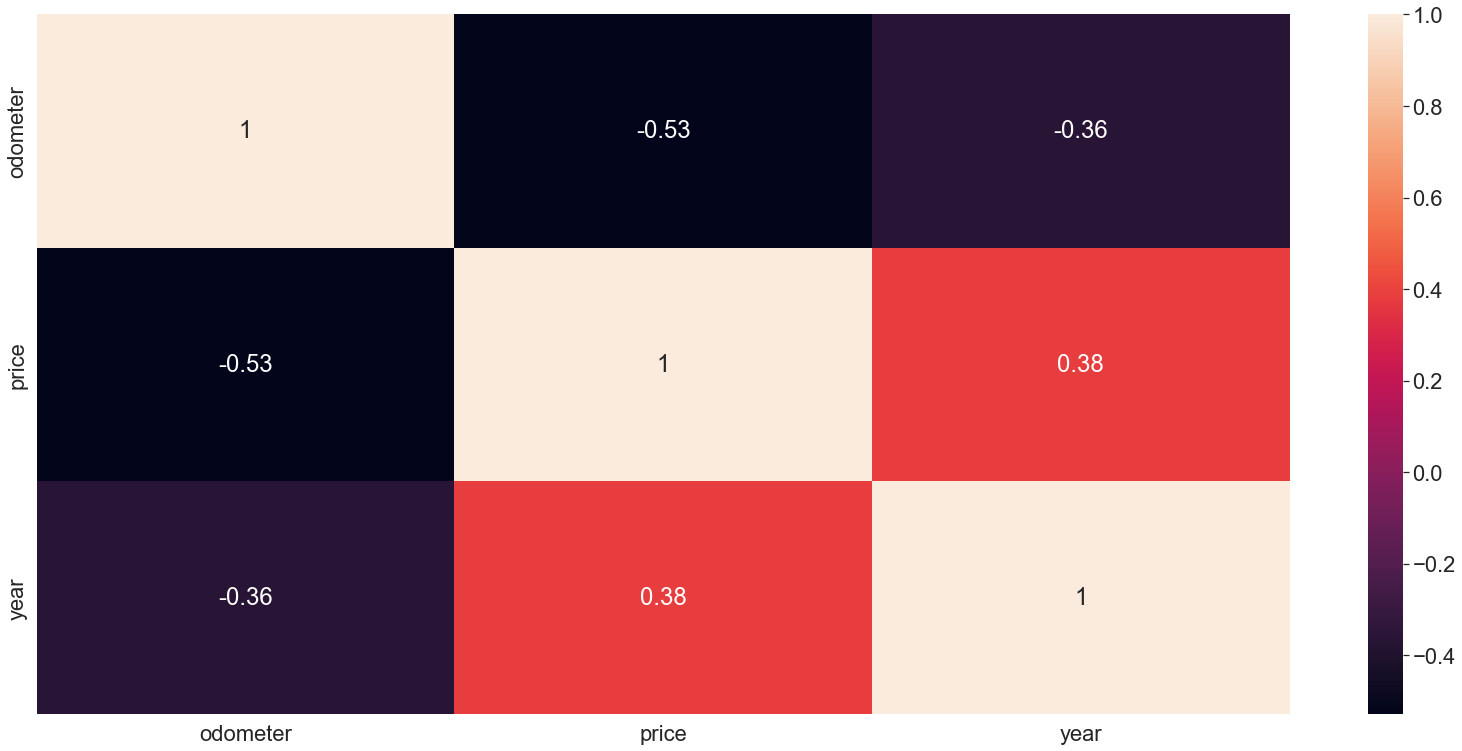

In [13]:
correlation = cars[["odometer", "price", "year"]].corr( method='pearson' )
sns.set(font_scale=2)
sns.heatmap(correlation, annot=True)

Text(0, 0.5, 'Mean price')

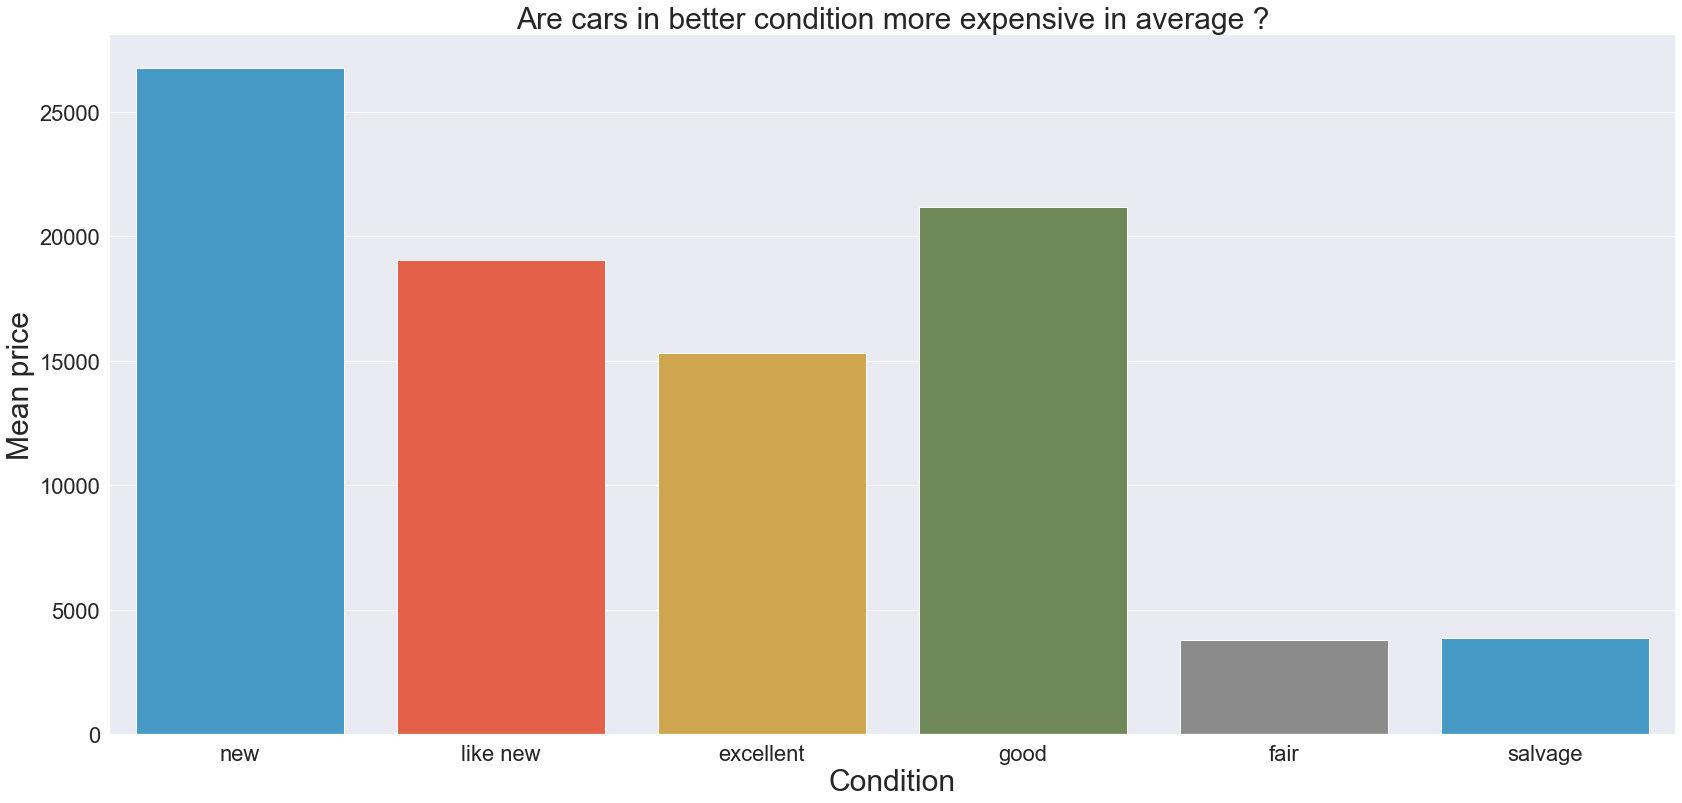

In [14]:
price_by_cond = cars[["condition", "price"]].groupby("condition").mean().reset_index()
condition_ordering = ["new", "like new", "excellent", "good", "fair", "salvage"]
p = sns.barplot(
    x="condition",
    y="price",
    order=condition_ordering,
    palette=five_thirty_eight,
    data=price_by_cond,)
p.set_title("Are cars in better condition more expensive in average ?", fontsize=30)
p.set_xlabel("Condition", fontsize=30)
p.set_ylabel("Mean price", fontsize=30)

In order to avoid negative predictions for the price, will model the log price and transform the price back at the end.

### Feature transformation

In [15]:
cars_sub = cars[["odometer", "state", "condition", "type"] + ["price"]]

In [16]:
cars_sub = pd.get_dummies(
    data=cars_sub, 
    prefix=["state", "condition", "type"],
    columns=["state", "condition", "type"])

In [17]:
cars_sub["logprice"] = np.log(cars_sub["price"])

### Model building

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [19]:
ss = StandardScaler()
cars_sub["odometer"] = ss.fit_transform(cars_sub["odometer"][:, np.newaxis])

/var/folders/4j/nwn878q577s1s_pmzlyckl_00000gn/T/ipykernel_1770/1683352043.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cars_sub["odometer"] = ss.fit_transform(cars_sub["odometer"][:, np.newaxis])


In [20]:
X_train, X_test, y_train, y_test = train_test_split(cars_sub, cars_sub["logprice"], test_size=0.2)

# drop the prediction columns so we don't use them when we do stepwise feature selection
X_train = X_train.drop(columns=["price", "logprice"])
X_test = X_test.drop(columns=["price", "logprice"])

In [21]:
def mse(y, yhat):
    return np.sqrt(mean_squared_error(np.exp(y), np.exp(yhat)))

def get_errors(model_name, y, yhat):
    mean_squared_error(y, yhat)
    
    return pd.DataFrame({
        "Model Name": model_name,
        "RMSE": np.sqrt(mean_squared_error(y, yhat))
    }, index=[0])

def get_score(model_name, scores):
    return pd.DataFrame({"Model Name": model_name, "RMSE": np.mean(scores)}, index=[0])

def compute_errors(model, name, X, y):
    yhat = model.predict(X)
    return get_errors(name, np.exp(y), np.exp(yhat))

rmse_score = make_scorer(mse, greater_is_better = False)

##### Baseline model
Dummy model that predicts the average for any observation. Will use this as baseline to compare the rest of the models.

In [22]:
yhat_baseline = np.repeat(y_test.mean(), len(y_test))
baseline_result = get_errors('Average Model', np.exp(y_test), np.exp(yhat_baseline))
baseline_result

,Model Name,RMSE
0,Average Model,15396.251517


#### Linear regression model

In [23]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

In [50]:
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring=rmse_score, cv=folds)
lm_result = get_score("Linear Regression CV", np.abs(scores))
lm_result

,Model Name,RMSE
0,Linear Regression CV,11518.631835


#### Lasso model and hyperparameter tuning for the regularization parameter

In [25]:
hyperparams = [{'alpha': np.arange(0.01, 10, 0.5)}]

In [26]:
model_cv = GridSearchCV(estimator = Lasso(), 
    param_grid = hyperparams, 
    scoring= rmse_score, 
    cv = folds, 
    verbose = 1,
    return_train_score=True
)
lasso_result = model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### Ridge model and hyperparameter tuning for the regularization parameter

In [27]:
model_cv = GridSearchCV(estimator = Ridge(), 
    param_grid = hyperparams, 
    scoring= rmse_score, 
    cv = folds, 
    verbose = 1,
    return_train_score=True
)
ridge_result = model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


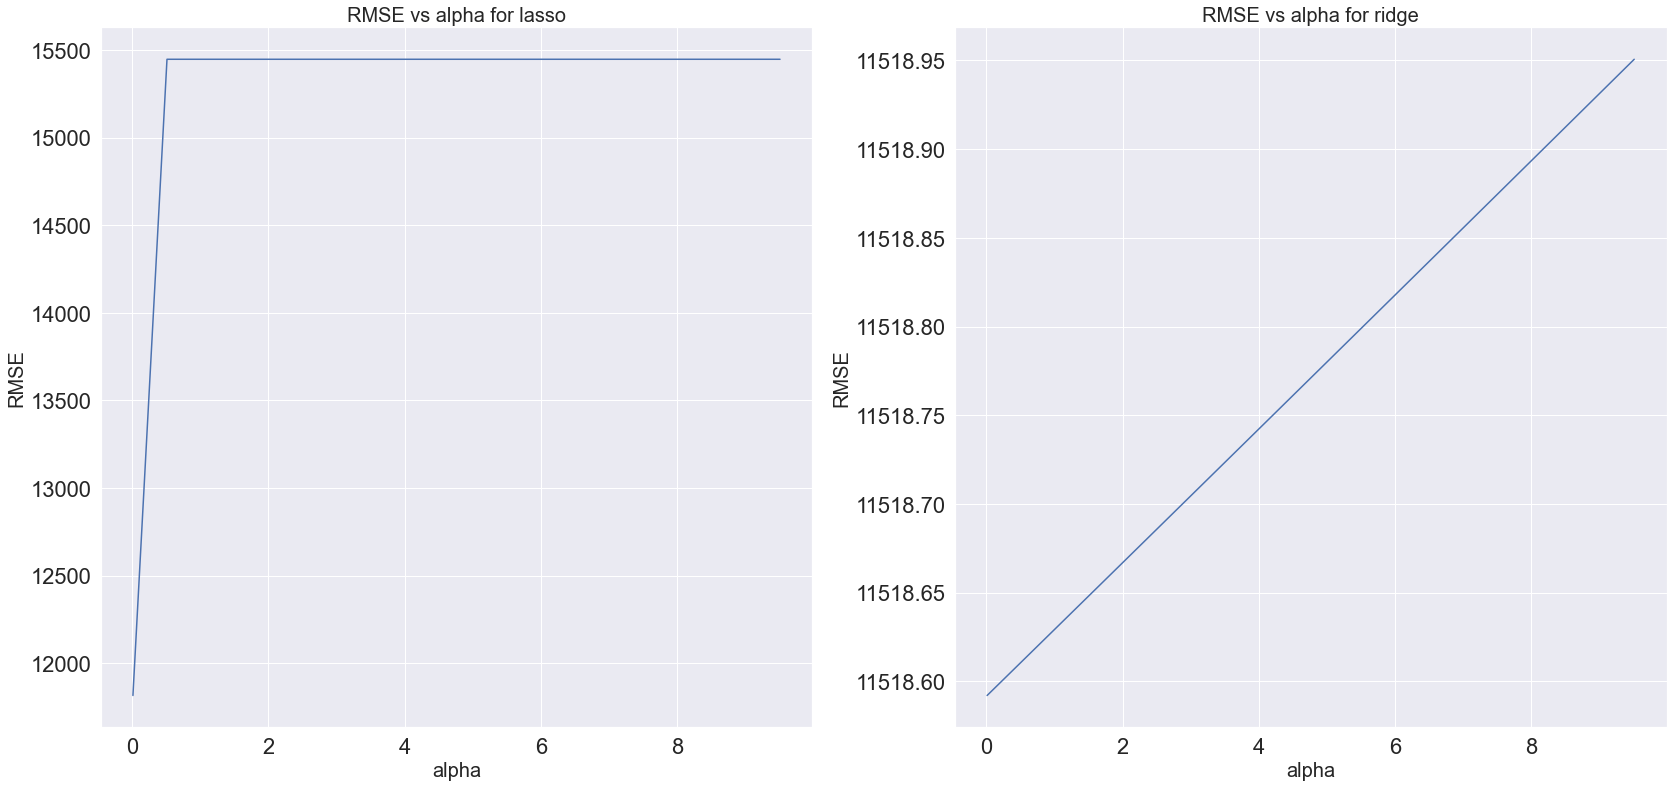

In [28]:
plt.subplot(1, 2, 1)
p = sns.lineplot(x=hyperparams[0]["alpha"], y=np.abs(lasso_result.cv_results_["mean_test_score"]))
p.set_title(f"RMSE vs alpha for lasso", fontsize=20)
p.set_xlabel("alpha", fontsize=20)
p.set_ylabel("RMSE", fontsize=20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.subplot(1, 2, 2)
p = sns.lineplot(x=hyperparams[0]["alpha"], y=np.abs(ridge_result.cv_results_["mean_test_score"]))
p.set_title(f"RMSE vs alpha for ridge", fontsize=20)
p.set_xlabel("alpha", fontsize=20)
p.set_ylabel("RMSE", fontsize=20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

In [45]:
lasso_result.best_estimator_.fit(X_train, y_train)
ridge_result.best_estimator_.fit(X_train, y_train)
regularized_models = pd.concat([
    compute_errors(lasso_result.best_estimator_, "Lasso Regression", X_test, y_test),
    compute_errors(ridge_result.best_estimator_, "Ridge Regression", X_test, y_test)
])


#### Random forrest regression

In [71]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
rf_result = compute_errors(rf, "Random Forrest Regression", X_test, y_test)

In [73]:
rf_hyperparams = [{"n_estimators": [1, 10, 30, 50]}]

In [74]:
model_cv = GridSearchCV(estimator = RandomForestRegressor(n_estimators=100, n_jobs=-1), 
    param_grid = rf_hyperparams, 
    scoring= rmse_score, 
    cv = folds, 
    verbose = 1,
    return_train_score=True
)
rf_result_cv = model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [85]:
rf_cv_result = compute_errors(rf_result_cv.best_estimator_, "Random Forrest Regression CV", X_test, y_test)

In [88]:
pd.concat(
    [regularized_models, baseline_result, lm_result, rf_result, rf_cv_result],
    ignore_index=True
).sort_values("RMSE")

,Model Name,RMSE
4,Random Forrest Regression,8037.413269
5,Random Forrest Regression CV,8055.872837
1,Ridge Regression,11440.288211
3,Linear Regression CV,11518.631835
0,Lasso Regression,11745.737670
2,Average Model,15396.251517
